In [1]:
import pandas as pd

#Plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import calendar 
import calplot # actually used

# Score model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from scipy import stats



/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Base Line model

In [2]:
url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url,header=1)

##  Mean

In [3]:

# Assuming df is your DataFrame
# 1. Calculate the mean of the actual delays
mean_delay = df['arrival_delay'].mean()

# 2. Create a new column with the mean delay as prediction
df['predicted_delay'] = mean_delay

# 3. Calculate MSE
mse = mean_squared_error(df['arrival_delay'], df['predicted_delay'])
print(f"Mean Squared Error (MSE): {mse}")

# Calculate other metrics if required:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(df['arrival_delay'], df['predicted_delay'])
print(f"Mean Absolute Error (MAE): {mae}")

# R^2 Score (not very meaningful in this context, but can be used)
r2 = r2_score(df['arrival_delay'], df['predicted_delay'])
print(f"R^2 Score: {r2}")
df = df.drop(columns='predicted_delay')
# COMMENT FOR REPORT
# Since r^2 = 1- ssres / sstot
# ssres is actual - pred -> since predis mean denominator and numerator is the same
# sstot is actual - mean

Mean Squared Error (MSE): 37596.94219419411
Mean Absolute Error (MAE): 138.98420152332488
R^2 Score: 0.0


# Dataframe setup

In [4]:
# Read the data
url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url, header=1)
#df = df.drop(columns=['weather', 'temperature', 'day_of_week', 'time_of_day'])
# Calculate z-scores for the 'arrival_delay' column
z_scores = stats.zscore(df['arrival_delay'])

# Get boolean array indicating the location of outliers
outliers = (z_scores > 7) | (z_scores < -7)

# Count the number of outliers
num_outliers = outliers.sum()

# Print the number of outliers
print(f"Number of outliers removed: {num_outliers}")

# Remove the outliers
df = df[~outliers]

# Verify the new size of the DataFrame
print(f"Size of the original DataFrame: {len(df)}")
#print(f"Size of the DataFrame after removing outliers: {len(df_no_outliers)}")
selected_values = [1, 5, 8, 12, 14, 16, 19, 20, 21, 23]
df = df[df['stop_sequence'].isin(selected_values)]

Number of outliers removed: 228
Size of the original DataFrame: 544875


# Only Daytype Model

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFECV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

def train_and_evaluate(df):
    # Split the dataset
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    # Results placeholder
    results = {
        'day_type': [],
        'best_model': [],
        'MSE': [],
        'MAE': [],
        'R^2': []  
    }

    # Function to train and evaluate Linear Regression with RFECV
    def train_lr_model(df_train_subset):
        x_train = df_train_subset.drop(['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], axis=1)
        y_train = df_train_subset['arrival_delay']

        model = LinearRegression()
        selector = RFECV(estimator=model, step=1, cv=KFold(5))
        selector = selector.fit(x_train, y_train)

        model.fit(x_train.iloc[:, selector.support_], y_train)
        
        return model, selector

    # Function to train Neural Network
    def train_nn_model(df_train_subset):
        x_train = df_train_subset.drop(['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], axis=1)
        y_train = df_train_subset['arrival_delay']

        model_nn = Sequential([
            Dense(32, activation='relu', input_dim=x_train.shape[1]),
            Dropout(0.001),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_nn.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        return model_nn

    for day_type in ['weekday', 'weekend']:
        df_train_subset = df_train[df_train['day_of_week'] == day_type]
        df_test_subset = df_test[df_test['day_of_week'] == day_type]

        # Train and evaluate Linear Regression model
        model_lr, selector = train_lr_model(df_train_subset)
        x_test = df_test_subset.drop(['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], axis=1).iloc[:, selector.support_]
        y_pred_lr = model_lr.predict(x_test)
        mse_lr = mean_squared_error(df_test_subset['arrival_delay'], y_pred_lr)
        mae_lr = mean_absolute_error(df_test_subset['arrival_delay'], y_pred_lr)
        r2_lr = r2_score(df_test_subset['arrival_delay'], y_pred_lr)
        # Train and evaluate Neural Network
        model_nn = train_nn_model(df_train_subset)
        y_pred_nn = model_nn.predict(df_test_subset.drop(['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], axis=1)).flatten()
        mse_nn = mean_squared_error(df_test_subset['arrival_delay'], y_pred_nn)
        mae_nn = mean_absolute_error(df_test_subset['arrival_delay'], y_pred_nn)
        r2_nn = r2_score(df_test_subset['arrival_delay'], y_pred_nn)

        # Choose the best model based on MAE
        if mae_nn < mae_lr:
            best_model = "NN"
            best_mse = mse_nn
            best_mae = mae_nn
            best_r2 = r2_nn
        else:
            best_model = "LR"
            best_mse = mse_lr
            best_mae = mae_lr
            best_r2 = r2_lr

        results['day_type'].append(day_type)
        results['best_model'].append(best_model)
        results['MSE'].append(best_mse)
        results['MAE'].append(best_mae)
        results['R^2'].append(best_r2)
    return pd.DataFrame(results)

results = train_and_evaluate(df)
print(results)


2023-10-16 12:04:12.008011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


298/298 [==============================] - 1s 2ms/step
  day_type best_model         MSE        MAE       R^2
0  weekday         LR  456.139671  14.528941  0.985040
1  weekend         LR  320.485326  12.528997  0.993448


# stop and daytime model (LR)

In [11]:
def train_evaluate_lr_model(df, n_folds=5):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    results = {
        'stop_sequence': [],
        'day_type': [],
        'R^2': [],
        'MAE': []
    }

    for stop_seq in df['stop_sequence'].unique():
        for day_type in ['weekday', 'weekend']:
            print(f"Processing stop_sequence {stop_seq} for {day_type}...")
            
            df_train_subset = df_train[(df_train['stop_sequence'] == stop_seq) & (df_train['day_of_week'] == day_type)]

            drop_columns = ['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"]
            x_train = df_train_subset.drop(columns=drop_columns, errors='ignore').astype('float32')
            y_train = df_train_subset['arrival_delay'].astype('float32')

            r2_scores_lr = []
            maes_lr = []

            # K-fold CV
            kf = KFold(n_splits=n_folds)
            for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
                print(f"Running Fold {fold + 1}...")

                x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                # Train and evaluate LR
                print("Training Linear Regression...")
                model_lr = LinearRegression().fit(x_train_fold, y_train_fold)
                y_pred_lr = model_lr.predict(x_val_fold)
                r2_scores_lr.append(r2_score(y_val_fold, y_pred_lr))
                maes_lr.append(mean_absolute_error(y_val_fold, y_pred_lr))

            # Save LR model
            best_r2 = np.mean(r2_scores_lr)
            best_mae = np.mean(maes_lr)
            if not os.path.exists("lr_models"):
                os.makedirs("lr_models")
            joblib.dump(model_lr, os.path.join("lr_models", f'lr_model_{stop_seq}_{day_type}.pkl'))

            results['stop_sequence'].append(stop_seq)
            results['day_type'].append(day_type)
            results['R^2'].append(best_r2)
            results['MAE'].append(best_mae)

    return pd.DataFrame(results)

def predict_with_lr_model(df):
    all_groups = []

    grouped = df.groupby(['stop_sequence', 'day_of_week'])
    for (stop_seq, day_type), group in grouped:
        lr_model_path = os.path.join("lr_models", f'lr_model_{stop_seq}_{day_type}.pkl')

        X = group.drop(columns=['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], errors='ignore').astype('float32')
        
        if os.path.exists(lr_model_path):
            model = joblib.load(lr_model_path)
            group['predicted_delay'] = model.predict(X)
        else:
            raise ValueError(f"No saved model found for stop_sequence: {stop_seq} and day_type: {day_type}")

        all_groups.append(group)

    result_df = pd.concat(all_groups)
    return result_df


In [7]:
results_lr = train_evaluate_lr_model(df)
print(results_lr)

Processing stop_sequence 1 for weekday...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 1 for weekend...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 5 for weekday...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 5 for weekend...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3..

In [12]:
pred = predict_with_lr_model(df)
pred.head()
# Extracting the actual and predicted values from the DataFrame
actual_values = pred["arrival_delay"].values
predicted_values = pred["predicted_delay"].values

# Computing R^2
r2 = r2_score(actual_values, predicted_values)

# Computing MAE
mae = mean_absolute_error(actual_values, predicted_values)

print(f"R^2: {r2:f}")
print(f"MAE: {mae:f}")



R^2: 0.988263
MAE: 13.800117


# Stop and Daytime (NN)

In [13]:
def train_evaluate_nn_model(df, n_folds=5):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    results = {
        'stop_sequence': [],
        'day_type': [],
        'R^2': [],
        'MAE': []
    }

    for stop_seq in df['stop_sequence'].unique():
        for day_type in ['weekday', 'weekend']:
            print(f"Processing stop_sequence {stop_seq} for {day_type}...")
            
            df_train_subset = df_train[(df_train['stop_sequence'] == stop_seq) & (df_train['day_of_week'] == day_type)]

            drop_columns = ['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"]
            x_train = df_train_subset.drop(columns=drop_columns, errors='ignore').astype('float32')
            y_train = df_train_subset['arrival_delay'].astype('float32')

            r2_scores_nn = []
            maes_nn = []

            # K-fold CV
            kf = KFold(n_splits=n_folds)
            for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
                print(f"Running Fold {fold + 1}...")

                x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                # Normalize the data for NN
                scaler = StandardScaler()
                x_train_normalized = scaler.fit_transform(x_train_fold)
                x_val_normalized = scaler.transform(x_val_fold)
                
                # Save the scaler
                if not os.path.exists("nn_scalers"):
                    os.makedirs("nn_scalers")
                joblib.dump(scaler, os.path.join("nn_scalers", f'scaler_{stop_seq}_{day_type}.pkl'))

                # Train and evaluate NN
                print("Training Neural Network...")
                model_nn = Sequential([
                    Dense(64, activation='relu', input_dim=x_train_normalized.shape[1]),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
                ])
                model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                model_nn.fit(x_train_normalized, y_train_fold, validation_data=(x_val_normalized, y_val_fold), epochs=100, batch_size=16, callbacks=[early_stopping], verbose=0)
                y_pred_nn = model_nn.predict(x_val_normalized).flatten()
                r2_scores_nn.append(r2_score(y_val_fold, y_pred_nn))
                maes_nn.append(mean_absolute_error(y_val_fold, y_pred_nn))

                # Save NN model
                best_r2 = np.mean(r2_scores_nn)
                best_mae = np.mean(maes_nn)
                if not os.path.exists("nn_models"):
                    os.makedirs("nn_models")
                model_nn.save(os.path.join("nn_models", f'nn_model_{stop_seq}_{day_type}.h5'))

            results['stop_sequence'].append(stop_seq)
            results['day_type'].append(day_type)
            results['R^2'].append(best_r2)
            results['MAE'].append(best_mae)

    return pd.DataFrame(results)

def predict_with_nn_model(df):
    all_groups = []

    grouped = df.groupby(['stop_sequence', 'day_of_week'])
    for (stop_seq, day_type), group in grouped:
        nn_model_path = os.path.join("nn_models", f'nn_model_{stop_seq}_{day_type}.h5')
        scaler_path = os.path.join("nn_scalers", f'scaler_{stop_seq}_{day_type}.pkl')

        X = group.drop(columns=['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], errors='ignore').astype('float32')
        
        if os.path.exists(nn_model_path):
            model = load_model(nn_model_path)
            # Load the scaler and normalize the data for NN
            scaler = joblib.load(scaler_path)
            X_normalized = scaler.transform(X)
            group['predicted_delay'] = model.predict(X_normalized).flatten()
        else:
            raise ValueError(f"No saved model found for stop_sequence: {stop_seq} and day_type: {day_type}")

        all_groups.append(group)

    result_df = pd.concat(all_groups)
    return result_df


### Creating Model

In [14]:
results_df_day = train_evaluate_nn_model(df)
print(results_df_day)

Processing stop_sequence 1 for weekday...
Running Fold 1...
Training Neural Network...
78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


KeyboardInterrupt: 

### USING the trained model

In [ ]:
pred = predict_with_nn_model(df)
pred.head()
# Extracting the actual and predicted values from the DataFrame
actual_values = pred["arrival_delay"].values
predicted_values = pred["predicted_delay"].values

# Computing R^2
r2 = r2_score(actual_values, predicted_values)

# Computing MAE
mae = mean_absolute_error(actual_values, predicted_values)

print(f"R^2: {r2}")
print(f"MAE: {mae}")



In [ ]:
results_df = train_and_evaluate_best_models(df)
print(results_df)

# NN vs LR

In [15]:
def select_best_model(df):
    lr_results = train_evaluate_lr_model(df)
    nn_results = train_evaluate_nn_model(df)

    best_model_results = pd.DataFrame(columns=['stop_sequence', 'day_type', 'best_model'])

    for stop_seq in df['stop_sequence'].unique():
        for day_type in ['weekday', 'weekend']:
            lr_mae = lr_results[(lr_results['stop_sequence'] == stop_seq) & (lr_results['day_type'] == day_type)]['MAE'].values[0]
            nn_mae = nn_results[(nn_results['stop_sequence'] == stop_seq) & (nn_results['day_type'] == day_type)]['MAE'].values[0]

            if lr_mae < nn_mae:
                best_model = 'LR'
            else:
                best_model = 'NN'

            best_model_results = pd.concat([best_model_results, pd.DataFrame({'stop_sequence': [stop_seq], 'day_type': [day_type], 'best_model': [best_model]})], ignore_index=True)

    return best_model_results
best_models=select_best_model(df)

Processing stop_sequence 1 for weekday...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 1 for weekend...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 5 for weekday...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3...
Training Linear Regression...
Running Fold 4...
Training Linear Regression...
Running Fold 5...
Training Linear Regression...
Processing stop_sequence 5 for weekend...
Running Fold 1...
Training Linear Regression...
Running Fold 2...
Training Linear Regression...
Running Fold 3..

/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 1 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 5 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 5 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Processing stop_sequence 8 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 8 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 12 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Processing stop_sequence 12 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 14 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 14 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 1ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 1ms/step
Processing stop_sequence 16 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Processing stop_sequence 16 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 19 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Processing stop_sequence 19 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 20 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 20 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 4ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 21 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 1s 5ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 0s 1ms/step
Processing stop_sequence 21 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Processing stop_sequence 23 for weekday...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 3ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 2ms/step
Processing stop_sequence 23 for weekend...
Running Fold 1...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 2...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 3...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 4...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step
Running Fold 5...
Training Neural Network...


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 2ms/step


/Users/jesperhelen/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
print(best_models)

   stop_sequence day_type best_model
0              1  weekday         NN
1              1  weekend         LR
2              5  weekday         LR
3              5  weekend         LR
4              8  weekday         LR
5              8  weekend         LR
6             12  weekday         LR
7             12  weekend         LR
8             14  weekday         LR
9             14  weekend         LR
10            16  weekday         LR
11            16  weekend         LR
12            19  weekday         LR
13            19  weekend         LR
14            20  weekday         NN
15            20  weekend         LR
16            21  weekday         LR
17            21  weekend         LR
18            23  weekday         LR
19            23  weekend         LR


In [17]:
def predict_with_best_models(df, best_model_results):
    all_groups = []

    for _, row in best_model_results.iterrows():
        stop_seq = row['stop_sequence']
        day_type = row['day_type']
        best_model = row['best_model']

        if best_model == 'LR':
            lr_model_path = os.path.join("lr_models", f'lr_model_{stop_seq}_{day_type}.pkl')

            if os.path.exists(lr_model_path):
                model = joblib.load(lr_model_path)
                X = df[(df['stop_sequence'] == stop_seq) & (df['day_of_week'] == day_type)].drop(columns=['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], errors='ignore')
                df_subset = df[(df['stop_sequence'] == stop_seq) & (df['day_of_week'] == day_type)]
                df_subset['predicted_delay'] = model.predict(X)
            else:
                raise ValueError(f"No saved LR model found for stop_sequence: {stop_seq} and day_type: {day_type}")

        else:
            nn_model_path = os.path.join("nn_models", f'nn_model_{stop_seq}_{day_type}.h5')
            scaler_path = os.path.join("nn_scalers", f'scaler_{stop_seq}_{day_type}.pkl')

            if os.path.exists(nn_model_path):
                model = load_model(nn_model_path)
                scaler = joblib.load(scaler_path)
                X = df[(df['stop_sequence'] == stop_seq) & (df['day_of_week'] == day_type)].drop(columns=['arrival_delay', 'day_of_week', 'time_of_day', "weather", "temperature"], errors='ignore').astype('float32')
                X_normalized = scaler.transform(X)
                df_subset = df[(df['stop_sequence'] == stop_seq) & (df['day_of_week'] == day_type)]
                df_subset['predicted_delay'] = model.predict(X_normalized).flatten()
            else:
                raise ValueError(f"No saved NN model found for stop_sequence: {stop_seq} and day_type: {day_type}")

        all_groups.append(df_subset)

    result_df = pd.concat(all_groups)
    return result_df


predicted_df = predict_with_best_models(df, best_models)
print(predicted_df)


484/484 [==============================] - 1s 3ms/step


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['predicted_delay'] = model.predict(X_normalized).flatten()
/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['predicted_delay'] = model.predict(X)
/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

484/484 [==============================] - 1s 2ms/step


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['predicted_delay'] = model.predict(X_normalized).flatten()
/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['predicted_delay'] = model.predict(X)
/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_40811/820116638.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

        Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  \
3186         20220110         4   44410              1             49   
3213         20220110         4   41370              1             65   
3240         20220110         4   41353              1             23   
3267         20220110         4   44413              1             72   
3294         20220110         4   45544              1            182   
...               ...       ...     ...            ...            ...   
540643       20220626         4   44418             23            237   
540670       20220626         4   44064             23            105   
540697       20220626         4   44059             23             20   
540724       20220626         4   41359             23            123   
540751       20220626         4   41345             23            164   

        dwell_time  travel_time_for_previous_section  scheduled_travel_time  \
3186             0                          

In [18]:
predicted_df.head()
# Extracting the actual and predicted values from the DataFrame
actual_values = predicted_df["arrival_delay"].values
predicted_values = predicted_df["predicted_delay"].values

# Computing R^2
r2 = r2_score(actual_values, predicted_values)

# Computing MAE
mae = mean_absolute_error(actual_values, predicted_values)

print(f"R^2: {r2}")
print(f"MAE: {mae}")



R^2: 0.9886239872274566
MAE: 13.680423029650349


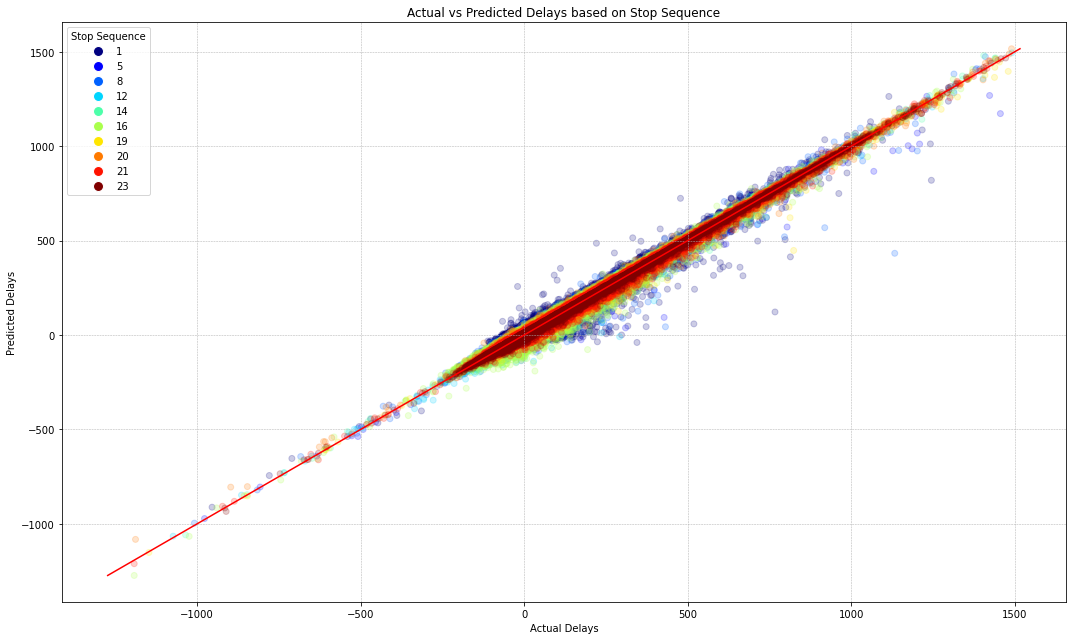

In [19]:
import matplotlib.pyplot as plt

# Values
actual_values = predicted_df["arrival_delay"].values
predicted_values = predicted_df["predicted_delay"].values
stop_sequences = predicted_df["stop_sequence"].values

# Unique stop sequences and their corresponding colors using a colormap
unique_sequences = np.unique(stop_sequences)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_sequences)))

# Create a dictionary mapping each stop sequence to a color
seq_to_color = dict(zip(unique_sequences, colors))

# Extract corresponding colors for our data
color_values = [seq_to_color[seq] for seq in stop_sequences]

# Plotting
plt.figure(figsize=(15, 9))
scatter = plt.scatter(actual_values, predicted_values, c=color_values, alpha=0.2)
plt.xlabel('Actual Delays')
plt.ylabel('Predicted Delays')
plt.title('Actual vs Predicted Delays based on Stop Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Creating a legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=seq_to_color[seq], markersize=10) for seq in unique_sequences]
plt.legend(legend_labels, unique_sequences, title="Stop Sequence")

max_val = max(max(actual_values), max(predicted_values))
min_val = min(min(actual_values), min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], 'r-')

plt.show()
